# Position Bot

This agent is created to demonstrate how Q-learning can be applied to a real-world problem. Retail trading is chosed as it has a lot of resemblances with many real-world problem such as ads bidding. We created the environment based on [minute-level bitcoin price data from Kaggle](https://www.kaggle.com/mczielinski/bitcoin-historical-data/version/14). We use the original Deep Q-learning implementation as stated in the paper [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). For more advanced implementations as well as other methods, check out our bi-weekly [Bangkok School of AI Reinforcement Learning Workshop](https://github.com/Datatouille/rl-workshop/).

**Disclaimer** You will not get rich with this algorithm. We do not hold any Bitcoin position as of 2018-10-31. Nonetheless, there are several good points for applying DRL to automated trading as described [Denny Britz](http://www.wildml.com/2018/02/introduction-to-learning-to-trade-with-reinforcement-learning/):

* Highly dynamic and uncertain; transaction fees, network latency, liquidity, competition, market conditions
* End-to-end model; totally removed from human emotions



## Colab

In [1]:
# #Uncomment if you are running from Google Colaboratory
# #data
# !wget https://www.dropbox.com/s/dwg0yfqb5kq749a/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv
# !mkdir data; cd data; mkdir bitcoin-historical-data
# !mv bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv data/bitcoin-historical-data

# #repo
# !wget https://github.com/cstorm125/rl_trader/archive/master.zip
# !unzip master.zip
# !cd rl_trader-master; mv position_bot ../

# # http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

## Import

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from collections import defaultdict, namedtuple, deque, Counter
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#rl
from position_bot.environment import SingleStockMarket
from position_bot.replay_memory import ReplayMemory
from position_bot.qnetwork import QNetwork
from position_bot.agent import VanillaQAgent
from position_bot.eval import *

DATA_PATH = 'data/'
#raw data from https://www.kaggle.com/mczielinski/bitcoin-historical-data/version/14
RAW_PATH = f'{DATA_PATH}bitcoin-historical-data/'

## Data Processing

We randomly chose a 100,000-minute period out of the data from 2012-01-01 to 2018-06-27. The price data includes `timestamp`, `open`, `high`, `low`, `close` and `volume-weighted adjusted price`. We processed the price data to be **minute-level percentage returns**. A column is added to denote `position` of the trade namely `short (-1)`, `nothing (0)` and `long (+1)`. Another column `commission` is also added to record percent commission per trade.

In [3]:
bitstamp_df = pd.read_csv(f'{RAW_PATH}bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
bitstamp_df.columns = ['timestamp','open','high','low','close','vol_btc','vol_usd','vwap']
#select only columns we're interested
bitstamp_df = bitstamp_df[['timestamp','open','high','low','close','vwap']]
#select only portions of timestamps we're interested
bitstamp_df = bitstamp_df.iloc[-1000000:-900000,:]
#for price reference
bitstamp_original = bitstamp_df.copy()
bitstamp_df.shape

(100000, 6)

In [4]:
bitstamp_df.tail()

,timestamp,open,high,low,close,vwap
2505852,1476057360,613.06,613.06,613.06,613.06,613.06
2505853,1476057420,613.06,613.06,613.06,613.06,613.06
2505854,1476057480,613.06,613.06,613.06,613.06,613.06
2505855,1476057540,613.06,613.06,613.06,613.06,613.06
2505856,1476057600,613.06,613.06,613.06,613.06,613.06


In [5]:
print(f"from {datetime.utcfromtimestamp(bitstamp_df.timestamp[2405857]).strftime('%Y-%m-%d %H:%M:%S')} \
      to {datetime.utcfromtimestamp(bitstamp_df.timestamp[2505856]).strftime('%Y-%m-%d %H:%M:%S')}")

from 2016-08-01 13:21:00       to 2016-10-10 00:00:00


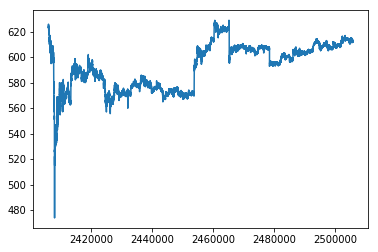

In [6]:
plt.plot(bitstamp_df.vwap)

In [7]:
bitstamp_df = bitstamp_df.set_index('timestamp')

#action; -1, 0, 1 = short, hold, long
bitstamp_df['position'] = 0

#reward
#log difference change
# bitstamp_df['vwap_returns'] = np.log(bitstamp_df['vwap'].shift(-1)) - np.log(bitstamp_df['vwap'])
#percentage change
bitstamp_df['vwap_returns'] = bitstamp_df['vwap'].shift(-1) / bitstamp_df['vwap'] - 1

#state
bitstamp_df.iloc[:,:5] = bitstamp_df.iloc[:,:5] / bitstamp_df.iloc[:,:5].shift(1) - 1
# bitstamp_df.iloc[:,:5] = np.log(bitstamp_df.iloc[:,:5]) - np.log(bitstamp_df.iloc[:,:5].shift(1))

#commission
bitstamp_df['commission'] = 0

#filter NaN
bitstamp_df = bitstamp_df.iloc[1:-1,:]
bitstamp_df = bitstamp_df.reset_index()

In [8]:
bitstamp_df.head()

,timestamp,open,high,low,close,vwap,position,vwap_returns,commission
0,1470057720,-0.000177,-0.000209,-0.000177,-0.000209,-0.000197,0,2.086677e-04,0
1,1470057780,0.000209,0.000209,0.000209,0.000209,0.000209,0,-1.919006e-04,0
2,1470057840,-0.000738,0.000000,-0.000738,0.000000,-0.000192,0,1.919374e-04,0
3,1470057900,0.000739,0.000000,0.000739,0.000000,0.000192,0,-4.814405e-05,0
4,1470057960,-0.000048,-0.000048,-0.000048,-0.000048,-0.000048,0,2.377628e-07,0


In [9]:
returns = (bitstamp_df['vwap_returns']+1)
print(f'Buy and Hold: {(returns * 1).prod()}')
position = np.random.choice([-1,0,1],bitstamp_df.shape[0])
print(f'Uniform Random: {(returns * position).prod()}')

Buy and Hold: 0.9840449438202138
Uniform Random: -0.0


## Environment

* Problem: Maximize risk-adjusted returns
* Environment: Bitcoin market from from 2016-08-01 13:21:00 to 2016-10-10 00:00:00
* Agent: vanilla q-learning agent
* States: 60-minute previous ohlc, vwap and position; **choice for window period**
* Actions: short, nothing, long
* Rewards: [differential sharpe ratio](https://www.investopedia.com/terms/s/sharperatio.asp); **choice between absolute and percentage**.
* Episodes: minute

In [150]:
env = SingleStockMarket(bitstamp_df)
env.reset().shape

(1, 6, 60)

In [41]:
env = SingleStockMarket(bitstamp_df)
state = env.reset()
episodes = []

def get_action(state):
    return(np.random.choice([0,1,2]))

for i in trange(10):
    action = get_action(state)
    next_state,reward,done,info = env.step(action)
    state = next_state

100%|██████████| 10/10 [00:00<00:00, 143.75it/s]


In [42]:
env.df.iloc[env.start_idx:env.idx,:]

,timestamp,open,high,low,close,vwap,position,vwap_returns,commission
60,1470061320,0.000000,0.000000,0.000000,0.000000,0.000000,-1,-0.002721,0.002003
61,1470061380,-0.002721,-0.002721,-0.002721,-0.002721,-0.002721,-1,0.000000,0.000000
62,1470061440,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000997
63,1470061500,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000785,0.002000
64,1470061560,0.002151,0.002151,0.000048,0.000048,0.000785,1,-0.001339,0.000000
65,1470061620,-0.002098,-0.002098,-0.000787,-0.000787,-0.001339,-1,0.000000,0.001999
66,1470061680,0.000000,0.000000,0.000000,0.000000,0.000000,-1,0.000000,0.000000
67,1470061740,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.001000
68,1470061800,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.000184,0.000000
69,1470061860,-0.000787,-0.000787,0.000000,0.000000,-0.000184,0,0.000000,0.000000


In [43]:
(env.df.iloc[env.start_idx:env.idx,:]['position'] * env.df.iloc[env.start_idx:env.idx,:]['vwap_returns'] + 1).prod()

1.0021649640566603

## Agent

A vanilla DQN agent consists of an experience replay buffer and two Q-networks. This is done so that we do not calculate the loss from the same network and thus destabilize the optimization process.

We gradually copy the parameters from the local Q-network, which gets optimized more often, to the target Q-network which never gets optimized directly.

### Replay Memory

Replay memory stores transitions from environment namely `state`, `action`, `reward`, and `next_state` to be sampled at given batch size and learned by the Q-networks later. This is done to prevent the networks from learning temporally correlated transitions. Prioritized experience replay can be used to sample transitions with larger losses aka "harder" examples; however, this needs to be reweighted by sample importance to prevent overfitting. The replay memory has a limited capacity to encourage the agent to learn from more recent transitions.

In [44]:
mem = ReplayMemory(10000)
env = SingleStockMarket(bitstamp_df)

state = env.reset()

def get_action(state):
    return(np.random.choice([0,1,2]))

for i in trange(10):
    action = get_action(state)
    next_state,reward,done,info = env.step(action)
    mem.add(state, action, reward, next_state, done)
    state = next_state
    
len(mem.sample(10))

100%|██████████| 10/10 [00:00<00:00, 150.82it/s]


5

When the agent performs the `step` method, it does two things:
1. Push the current transition into replay memory.
2. Sample a transition from the replay memory to optimize the local Q-network.

### Networks

The Q-networks have a simple architecture of feature extraction by 1D convolution and a head with fully-connected layers. Such simpler networks tend to work better than for instance networks with batch normalization and dropout layers. Noisy linear layers can be substituted to encourage exploration.

In [45]:
m = QNetwork()
m

QNetwork(
  (feature): Sequential(
    (0): Conv1d(6, 12, kernel_size=(6,), stride=(2,))
    (1): ReLU()
    (2): Conv1d(12, 24, kernel_size=(6,), stride=(3,))
    (3): ReLU()
  )
  (head): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [46]:
x = mem.sample(10)[0]
m(x)

tensor([[-0.0443,  0.0314, -0.0630],
        [-0.0520, -0.0065,  0.0047],
        [-0.0208,  0.0607, -0.0403],
        [-0.0478,  0.0251, -0.0719],
        [-0.0119,  0.0340, -0.0151],
        [-0.0677,  0.0412, -0.0878],
        [-0.0181,  0.0711, -0.0655],
        [-0.1015,  0.0031, -0.0392],
        [-0.0620,  0.0204, -0.0367],
        [-0.0085,  0.0464, -0.0131]], grad_fn=<ThAddmmBackward>)

### Training

Since this is a continuous task, we train for an arbitrary number of steps. To for the agent to explore more during the beginning of the training, we use epsilon-greedy policy, meaning we start out by having the agent explores almost completely then gradually decay the rate of exploration as time goes on.

In [47]:
env = SingleStockMarket(bitstamp_df)
mem = ReplayMemory(10000)
a = VanillaQAgent(replay_memory = mem)

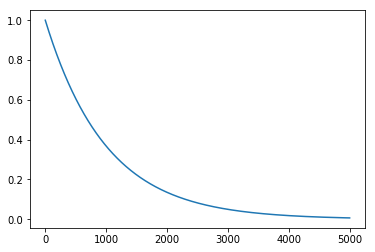

In [55]:
eps = []
for i in range(5000):
    eps.append(a.get_eps(i))
plt.plot(eps)

In [49]:
state = env.reset()
for i in trange(10000):
    #select action
    action = a.act(state,i)  

    #step
    next_state,reward,done,info = env.step(action)                
    a.step(state,action,reward,next_state,done)

    state = next_state                          

100%|██████████| 10000/10000 [01:38<00:00, 101.29it/s]


In [62]:
# model_name = f'{DATA_PATH}models/vanilla_q.pth'
# df_name = f'{DATA_PATH}models/vanilla_q.csv'
# # a.save_agent(model_name,df_name)
# a.load_agent(model_name,df_name)
env.idx

10060

## Diagnostics

Reinforcement learning, especially Q-learning, is notoriously difficult to train and perhaps even more difficult to debug. Here are some guidelines you can check when things do not go as planned.

## Benchmarking

Always have a decent benchmark using rule-based or supervised models. Here we use `buy and hold` and a 10-period simple moving average momentum strategy as benchmark. If your intended metric is not optimized but some other related metrics are (for instance, sharpe ratios not optimized but returns are), you may want to recreate your rewards.

In [108]:
model_sharpes = []
buy_sharpes = []
mom_sharpes = []
model_returns = []
buy_returns = []
mom_returns = []

for i in trange(100,2000):
    env.idx = i
    model_sharpes.append(model_eval(env)[0])
    buy_sharpes.append(buy_eval(env)[0])
    mom_sharpes.append(momentum_eval(env)[0])
    
    model_returns.append(model_eval(env)[1])
    buy_returns.append(buy_eval(env)[1])
    mom_returns.append(momentum_eval(env)[1])

100%|██████████| 1900/1900 [02:48<00:00, 11.24it/s]


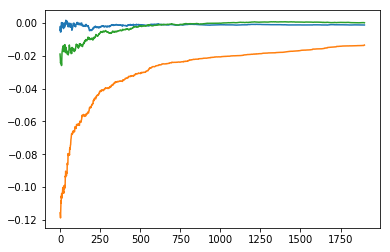

In [109]:
plt.plot(model_sharpes)
plt.plot(buy_sharpes)
plt.plot(mom_sharpes)
plt.show()

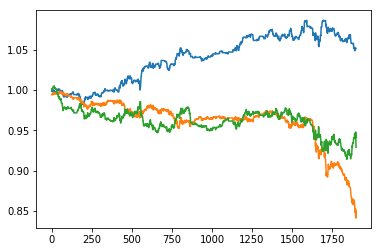

In [110]:
plt.plot(model_returns)
plt.plot(buy_returns)
plt.plot(mom_returns)
plt.show()

### Q-Networks

Plot the losses of the local network. The losses should quickly drop and stabilizes. On the other hand, if it stabilizes too fast, you might want to increase exploration with slower epsilon decay or a noisy linear layer.

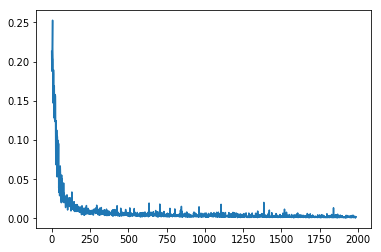

In [51]:
plt.plot(a.losses)

### Feature Extractor

Visualize the convolution layers of the local Q-network to see if the weights are actually capturing features that it should. If not, you might need to tune your feature extraction layers.

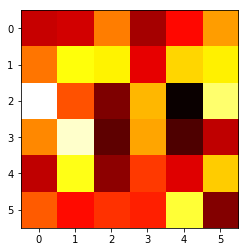

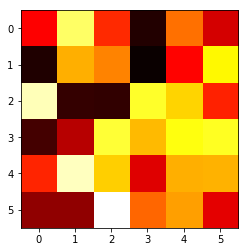

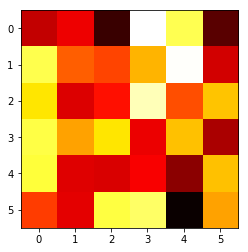

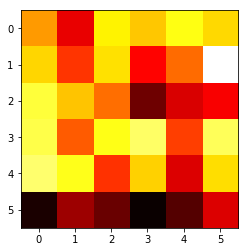

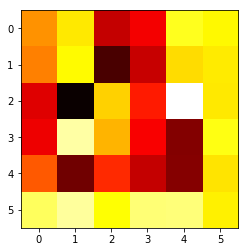

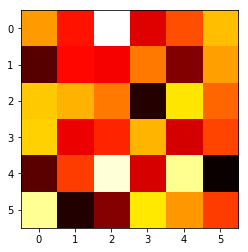

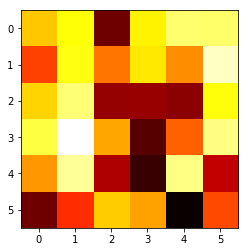

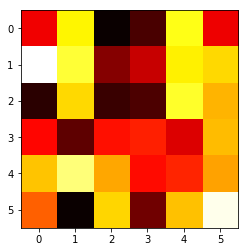

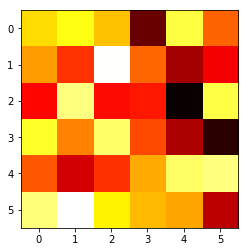

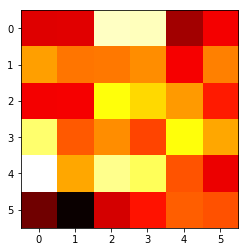

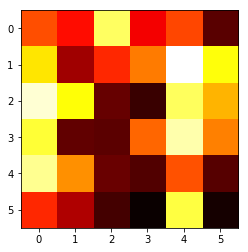

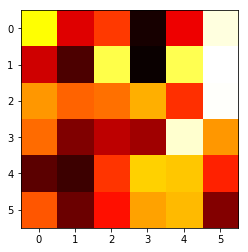

In [147]:
for i in range(12):
    x = np.array(a.qnetwork_local.state_dict()['feature.0.weight'][i,:,:].data) #weight idx, kernel size, state dimension
    plt.imshow(x, cmap='hot', interpolation='nearest')
    plt.show()

### Agent's Actions

Check if the actions chosen make sense intuitively. For instance, our time period is overall bear market but it has a short sharp drop in the beginning and gradual recovery. The positions it placed should reflect this trend. Otherwise, there is something wrong with the way your agent handles the action selection or learning process.

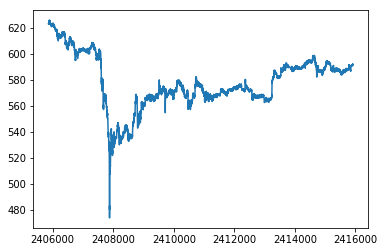

In [11]:
plt.plot(bitstamp_original.iloc[:env.idx,:]['vwap'])

In [56]:
Counter(env.df.iloc[:env.idx,:]['position'])

Counter({1: 3017, -1: 1364, 0: 5679})